# Quantum Computing

In [ ]:
#@title "Software Installs [Run me!]"
!pip install qiskit >& /dev/null

In [ ]:
import numpy as np
import qiskit
print(np.__version__)
print(qiskit.__version__)

1.18.5
0.15.2


In [ ]:
#@title "Other Imports [Run me!]"
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import BasicAer
from qiskit import execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

import warnings
# 'error' to stop on warns, 'ignore' to ignore noise
warnings.filterwarnings('ignore')

from functools import reduce
from math import log
import itertools

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

We will also use some code and functions [originally written by Dr. C. Moran](https://www.frontiersin.org/articles/10.3389/fphy.2018.00069/full) for qubit visualization.

In [ ]:
#@title "NumPy Qubits and Bloch sphere plotting functions [Run me!]"
zero_qubit=np.matrix('1; 0')
one_qubit=np.matrix('0; 1')
plus_qubit=1/np.sqrt(2)*np.matrix('1; 1')
minus_qubit=1/np.sqrt(2)*np.matrix('1; -1')
clockwisearrow_qubit=1/np.sqrt(2)*np.matrix([[1],[np.complex(0,1)]])
counterclockwisearrow_qubit=1/np.sqrt(2)*np.matrix([[1],[-np.complex(0,1)]])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def get_bloch_coordinates(qubit):
    def get_x_bloch(qubit):
        qubit_x_basis=1./np.sqrt(2)*np.matrix('1 1; 1 -1')*qubit
        prob_zero_qubit=(qubit_x_basis.item(0)*qubit_x_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_x_basis.item(1)*qubit_x_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit

    def get_y_bloch(qubit):
        qubit_y_basis=1./np.sqrt(2)*np.matrix('1 1; 1 -1')*np.matrix([[1,0],[0,-np.complex(0,1)]])*qubit
        prob_zero_qubit=(qubit_y_basis.item(0)*qubit_y_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_y_basis.item(1)*qubit_y_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit

    def get_z_bloch(qubit):
        qubit_z_basis=qubit
        prob_zero_qubit=(qubit_z_basis.item(0)*qubit_z_basis.item(0).conjugate()).real
        prob_one_qubit=(qubit_z_basis.item(1)*qubit_z_basis.item(1).conjugate()).real
        return prob_zero_qubit-prob_one_qubit
    return (get_x_bloch(qubit),get_y_bloch(qubit),get_z_bloch(qubit))

def plot_bloch(qubit,color='b',ax=None):
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="k",alpha=.1)
        ax.grid(False)

    coordinates=get_bloch_coordinates(qubit)
    ax.quiver([0],[0],[0],[coordinates[0]],[coordinates[1]],[coordinates[2]],length=1,color=color,arrow_length_ratio=0.3)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('x: |"-"> to |"+">')
    ax.set_ylabel('y: |"↺"> to |"↻">')
    ax.set_zlabel('z: |"1"> to |"0">')
    ax.view_init(azim=20)
    return ax

i_ = np.complex(0, 1)
H = 1. / np.sqrt(2) * np.matrix('1 1; 1 -1')
X = np.matrix('0 1; 1 0')
Y = np.matrix([[0, -i_], [i_, 0]])
Z = np.matrix([[1, 0], [0, -1]])

def pretty_print_number(amnt):
    the_string = locale.format_string("%12.0f", amnt, grouping=True)
    print("{}".format(the_string))

This is [Google Colaboratory](https://colab.research.google.com) notebook. It gives us a way to run code on a machine sitting in the [Google Cloud](https://cloud.google.com/). And it is free! It is a great platform for sharing code and programming projects. You do probably need a Google account for maximum benefit (if you want to save notebooks, etc.).

The notebook model for running code is very popular. Notebooks supports markup (using [Markdown](https://daringfireball.net/projects/markdown/)) as well, so they are good for building rich documents with graphics, formatted text, and program execution. The most famous notebook software out there is [Project Jupyter](https://jupyter.org/). It is easy to set up on a personal computer if you are so inclined. If you don't want to bother with any setup though, Colab is a good option.

Notebooks can do a lot of fancy things, but the main things you need to know are how to run a "cell" and how to edit one. You can just click on a cell to get an editor, and use "shift+return" to run the cell (either code or markup).

The programming language backing our work here is [Python](https://www.python.org/). Python is a popular, user-friendly, dynamic programming language. If you're completely new to Python, the [official "getting started" information](https://wiki.python.org/moin/BeginnersGuide) is great. Don't worry if you've never seen Python code before - it is very readable and you'll be able to get a lot out of this notebook even if you don't understand all of the code. (And there will be an additional quantum programming element at the end that doesn't even require Python!)

This notebook was developed with [NumPy](https://numpy.org/) version 1.17.3 and [Qiskit](https://qiskit.org/) version 0.10.0 (Qiskit-terra is 0.13 - they make it confusing). It may not function correctly with different software versions.

## Computation is performed by physical systems

Let's start with the big picture! What _is_ computation?

From a certain perspective, computation is _simulation_ - it is manipulating a physical system in search of a result where the system is an abstract representation of a real problem we care about.

Think about an abacus - it is a physical system, and if you follow some rules for moving the beads around, you can interpret the new position of the beads as reflecting a arithmetic operation. The abacus doesn't know it added numbers, we just know to interpret the states as such.

But an abacus is slow. Today we use electronic devices. To add two numbers on an electronic device we develop an _algorithm_, which tells us how to relate an arithmetic operation to the manipulation of binary states and then we simulate that operation by running currents and measuring voltages.

### Addition with binary numbers

To add two numbers with a computer, we first represent them in [_binary_](https://en.wikipedia.org/wiki/Binary_number). Recall that binary numbers are base-2. We're used to base-10, but base-2 (and base-16) are very useful in computer science. A base 10 number looks like this:

```
765 = 7 x 10^2 + 6 x 10^1 + 5 * 10^0
```

The rightmost digit is 5 times ten to the power _zero_. The next digit moving to the left is 6 times ten to the power of one. Finally, at the leftmost edge we have 7 times ten to the power of two. Binary numbers are essentially the same, but instead of ten to some power per place, we use two to some power:

```
0b101 = 1 x 2^2 + 0 x 2^1 + 1 x 2^0
```

Here, the rightmost digit is 1 times two to the power zero. Moving left we have 0 times two to the power of one. Finally, on the leftmost edge we have 1 times two to the power of two. In base-10 we would write this number as "5".

Note that in base-10 digits range between 0 and 9 and in base-2 they range between 0 and 1.

We like binary for computation with physical systems because we can represent binary numbers with two-level systems, and two-level systems are simple. There are many _electronic_ two-level systems that we can manipulate very quickly.

So, we set up a set of registers with "positive" (1) and "negative" (0) values (imagine little magnets or different voltage levels, etc.). Then we set up a third register to hold the result (and one for the "carry") and flip the positive and negative values in the results register based on a scan over the first and second registers (and the carry!) combined with some simple rules:

<img src="https://www.dropbox.com/s/wgfi9lpl4qqbxv3/add_two_binary_numbers_rules.png?dl=1" height="90">

<img src="https://www.dropbox.com/s/dlkgen3tuk4hecv/add_three_binary_numbers_rules.png?dl=1" height="90">

Here we add 6 and 7:

<img src="https://www.dropbox.com/s/1rtvegu05pxfrab/binary_addition.png?dl=1" height="150">

For more, see this [web app](https://chortle.ccsu.edu/AssemblyTutorial/zAppendixE/binaryAdd.html).

In [ ]:
0b110 + 0b111

13

In [ ]:
bin(13)

'0b1101'

Remember, there are 10 kinds of people in the world...

(Less funny when we write this as "0b10 kinds of people in the world"...)

## Classical circuit model


It is reasonable to ask: "okay, once you have these rules for binary addition, how do you _implement_ them in hardware?"

We use [transistors to implement _logic gates_](https://en.wikipedia.org/wiki/Transistor–transistor_logic):

<img src="https://www.dropbox.com/s/2icjygcysqrkqeo/LogicCircuitsWithTables1.png?dl=1" alt="Logic circuits">

<img src="https://www.dropbox.com/s/dkas7n803ypiz3e/LogicCircuitsWithTables2.png?dl=1" alt="Logic circuits">

Of course, we can implement the more "complex" logic gates with compositions of simpler logic gates:

<img src="https://www.dropbox.com/s/n5fdxmohxel6nfk/xor_function_classical_circuit.png?dl=1" height="300" alt="XOR function">

| XOR Function | $x_2 = 0$   | $x_2 = 1$   |
|:----------:|:-----------:-|:-------------:|
| $x_1 = 0$ |      $0$     |     $1$      |
| $x_1 = 1$ |      $1$     |     $0$      |

Here $[x_1, x_2]$ form a register of bits that we can perform operations on. We don't usually think this way, but in principle we can write **ALL** of our programs (e.g. every piece of sofrware in your laptop and phone) using _only_ NAND gates.

You can see how you would implement a table like this one with logic gates:

<img src="https://www.dropbox.com/s/wgfi9lpl4qqbxv3/add_two_binary_numbers_rules.png?dl=1" height="90">

You need two inputs and two outputs. This function is called a _Half Adder_:

<img src="https://www.dropbox.com/s/3a93go55dqayy7u/HalfAdderWithTable.png?dl=1" alt="Half Adder">

We may combine Half Adders to build a _Full Adder_:

<img src="https://www.dropbox.com/s/bptqkr6p4j0bg4d/FullAdderWithTable.png?dl=1" alt="Full Adder">

We can use Full Adders to compute the elements of problems like the one we started with, but we may also cascade Full Adders to add numbers directly. So, for example, for two 3-bit numbers, we have:

<img src="https://www.dropbox.com/s/fg4tu81iwgv1y7h/CascadedAdder.png?dl=1" alt="Cascaded Adders">

**Exercise:** Verify this circuit performs addition correctly.

This is looking at software at a pretty low level. It isn't quite the bottom since we aren't getting into how you actually implement transistor logic gates, but this is close to the bottom of the "software stack." These logic gates are built into the _hardware_ directly. When you run current through them, they mechanically churn out the "right" answer.

From here, you layer on different types of abstractions. You can build circuits to do things besides add binary numbers, and then you can bundle collections of circuits to start to do more complex tasks. Some circuits you use so often that you "hard code" them right into the silicon. Others you might make more flexible. People have been working on optimizing these choices for decades, and working in parallel to make transistor logic gates smaller and faster.

This is the foundation of what we call _classical computing_, where the "classical" means that the logic in our circuits is restricted to the language of classical physics. (More on what that means in a bit when we may contrast it with quantum computing.)

## Limits to computation

Why can't we compute _everything_ we might want to with this computing paradigm?

Well - in some senses we _can_, but there are practical limits imposed by required resources: time, energy, etc. Remember, we have to _build_ a physical system that can simulate a calculation by analogy. We can write down an algorithm to solve a problem, but if it requires the lifetime of the universe to simulate on some physical device and provide an answer, we haven't actually solved the problem in the way we care about. For example, we can tell someone algorithmically how to build a molecule to cure cancer, but we can never tell them what that molecule actually is!

The computational devices we're used to (transistor based implementations of logic gates) face several key limitations in the search for faster, better, and cheaper computation.

Chips with transistors smaller than 7 nm have proven to be extremely costly to fabricate and it is unclear whether anything smaller than 3 nm is viable. This would signal the actual end of [Moore's Law](https://en.wikipedia.org/wiki/Moore%27s_law). We have even more serious problems with [Dennard Scaling](https://en.wikipedia.org/wiki/Dennard_scaling). Parallelizing our algorithms helps, but that approach is bounded because ultimately we simply become dominated by the pieces of the algorithm that we can't parallelize.

<img src="https://www.dropbox.com/s/02a9tpkbcpm46t4/limits_to_classical_comp_m_alam_rigetti.png?dl=1">

Figure courtesy of M. Sohaib Alam, [Rigetti Computing](https://www.rigetti.com/).


Maybe the problem here is that we're trying to use the wrong hardware (two-level digital logic in silion) to simulate a given problem. Maybe we should build a different computation device? For example, if we wanted to simulate molecules to look for new drugs to cure cancer, we could build some system out of molecules themselves that would be more naturally suited to the problem.

Good idea! We call this "chemistry", and it is great. The problem is these "simulators" are so complex that they are impossible to program. We can set up experiments to answer a specific question, but we can't automate them or put them into other algorithms.

What we want is an extension to our current paradigm that gives us more simulation power or one that lets us get around some of the physical limitations we're dealing with.

## Quantum computing

Let's talk about an approach to computation that deals with both of these problems. We've mentioned computing properties of molecules already - why is this hard? It turns out the answer lies in the fact that molecules are [_quantum_](https://en.wikipedia.org/wiki/Quantum_mechanics) systems. This means we need a _huge_ number of digital numbers to describe them, which is why digital simulators struggle with them. The physics is just wrong for our simulator.

Do we have a computing device that can simulate the physics of a quantum system? Our best candidate is a _quantum computer_.

Quantum computing is the manipulation of _quantum states_ to perform a computation. The major difference with the classical model is we now use quantum bits, or **qubits**. Qubits can access _superpositions_ of states (as opposed to only 0 and 1) and may be _entangled_. Entanglement and superposition mean the state space for a set of $n$ qubits is $2^n$ - it grows exponentially with the number of qubits.


<img src="https://www.dropbox.com/s/m8tcwnwil13ecxa/qubit_scaling_m_alam_rigetti.png?dl=1">

Figure courtesy of M. Sohaib Alam, [Rigetti Computing](https://www.rigetti.com/).

## Quantum supremacy?

Exponential growth in the available state space is what allows for the concept of [quantum supremacy](https://en.wikipedia.org/wiki/Quantum_supremacy).

In October this year, [Google announced](https://ai.googleblog.com/2019/10/quantum-supremacy-using-programmable.html) that they built and operated a quantum computer for a supremacy demonstration. It was the the sort of rare science news that actually broke through to mainstream media publications.

You can read more about quantum supremacy [here](https://www.scottaaronson.com/blog/?p=4372) and some dissent about whether this milestone was truly achieved [here](https://www.ibm.com/blogs/research/2019/10/on-quantum-supremacy/). If it was, it is a very big deal!

The basic idea is Google used a quantum computer to sample from a very difficult to calculate probability distribution and proved that they were actually correctly sampling from the distribution 0.2% of the time (the rest of the time the computer was producing gibberish). Is this useful? Not in and of itself, but it demonstrated that it was possible to build a quantum computer capable of performing calculations that are prohibitively expensive for a classical computer (there were skeptics who claimed this was impossible to achieve).

## Single qubits and the Bloch sphere

Back to qubits... why are they so special? Classical bits are binary numbers - they may only have the value of 0 or 1. But qubits offer a richer set of options. We may describe a single qubit state as a two-level system. We'll use the notation:

$$
|\psi\rangle = \begin{pmatrix} \alpha \\ \beta \end{pmatrix} = \alpha \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \beta \times \begin{pmatrix} 0 \\ 1 \end{pmatrix} \equiv \alpha |0\rangle + \beta |1\rangle
$$

where $|0\rangle$ and $|1\rangle$ are _basis states_ in a basis we call the computational basis. Think of them like "heads" and "tails" on a coin.

We'll call $|0\rangle$ the "zero qubit" and we'll call $|1\rangle$ the "one qubit" and let the basis be implicit. $\alpha$ and $\beta$ are complex numbers obeying the _normalization_ condition

$$
\alpha^2 + \beta^2 = 1
$$

Not the implication - even single qubits may exist in a _superposition_, or linear combination, of states. We often use a construct called the [Bloch Sphere](https://en.wikipedia.org/wiki/Bloch_sphere) to represent a (single) qubit visually. The Bloch sphere gives us a way to visualize how qubits with different $\alpha$ and $\beta$ values "look" by mapping those points onto a two-dimensional surface (best visualized as a point on a sphere):


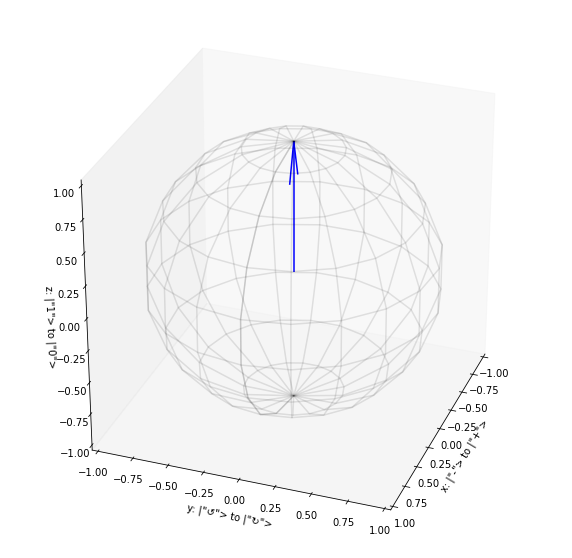

In [ ]:
plot_bloch(zero_qubit)

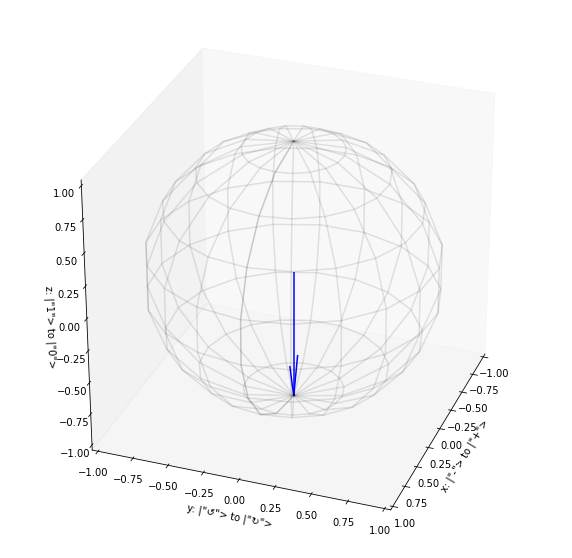

In [ ]:
plot_bloch(one_qubit)

Suppose we choose an arbitrary $\alpha$ and $\beta$ pair? Recall the restriction that $\alpha^2 + \beta^2$ must equal 1.

In [ ]:
eighty_twenty_qubit = np.sqrt(0.8)*zero_qubit - i_ * np.sqrt(0.2)*one_qubit
plot_bloch(eighty_twenty_qubit)

NameError: ignored

**Exercise:** Play with this code and draw some new qubits. One important piece of information:

$$
\alpha^2 + \beta^2 = 1
$$

really means

$$
\alpha^* \alpha + \beta^* \beta = 1
$$

where $\alpha^*$ is the _complex conjugate_ of $\alpha$. Here, that just means $i \to -i$, so

$$
(2 + 3i)^* = 2 - 3i
$$

etc.


Note that classical bits cannot pull off this superposition trick. If we plotted a classical bit on the Bloch sphere, it could only live at the poles. Meanwhile, a qubit can appear anywhere on the surface of the sphere:

<img src="https://www.dropbox.com/s/4sw0n07iy7o1zs3/classical_quantum_bloch.png?dl=1" height="200">

## Multi-qubit states

We can string together multiple bits to make larger numbers.  If we label the _state_ of our binary system that represents 0 as $|0\rangle$ and the state that represents 1 as $|1\rangle$, then a valid state might be:

$$
x = |01101\rangle
$$

where these values can be thought of as numbers in some register (perhaps on a computer).

Superpositon means the mathematical space grows _exponentially_ in the number of qubits. Specifically, quantum state space grows like $2^n$, where $n$ is the number of qubits. We can describe a two-bit classical system with one vector - it is definitely "00" or "01", etc. This requires only one number.

But a quantum system may have a non-zero _amplitude_ in all of the possible states, so

$$
\psi = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle
$$

is a valid quantum state. This requires keeping track of four numbers. For a two-qubit system, this is no problem, but, for example, a molecule in a chemistry problem might require hundreds of qubits to describe. So...

In [ ]:
pretty_print_number(2**200)

1,606,938,044,258,990,275,541,962,092,341,162,602,522,202,993,782,792,835,301,376


Of course, there is still a normalization condition on these terms. For example:

$$
\psi = \frac{1}{\sqrt{2}} \left( |001\rangle + |110\rangle \right)
$$

The sum of the squares of the coefficients is 1. This is _always_ the case for a valid quantum state.

Note that here, we have _one state_ that is a combination of values. Based on this _wavefunction_, we cannot say the first bit of the register is definitively a 0 or a 1. It is a combination. You might think - well, it is one or the other but we just don't know. This would imply the existence of _hidden variables_ in quantum mechanics. It is beyond the scope of this lecture to handle hidden variables, but there are definitive physical experiments you may conduct that show there are no hidden variables. A quantum state really can be a combination of states.

## Quantum measurement

Measurement is a two-step process - first we must choose a _basis_, and second we choose what we are measuring. The measurement itself will always give us a state in that basis.

An example of a basis is the "0/1" basis we've been implicitly using so far. Who choose the direction of "0"? Once that is fixed, the direction of "1" is fixed (on the Bloch sphere), but isn't the initial choice arbitrary?

Well, yes, it is. Perhaps there is a natural asymmetry in our problem space (defined by a physical magnet, for example), but perhaps not. When we talk about _bases_ we are referring to other valid choices for that initial direction. We can always transform from one basis to another. (When we do have a natural asymnmetry this can have important consequences for measurement.)

When we make a measurement, we "collapse the wave function". This means that if our original state was in a superposition, it no longer is. Measured states cease to be in superposition and they remain in the state they collapsed to no matter how many addition measurements we perform. The _probability_ a measurement is equal to the square of the amplitude of its superpositions.

So, if our initial state is
$$
\psi = \sqrt{0.8} |0\rangle + \sqrt{0.2} |1\rangle
$$
we have an 80% chance of measureing $|0\rangle$ and a 20% chance of measuring $|1\rangle$ and every subsequent measurement will give the same answer - after the measurement the superposition is destroyed and we no longer have a probabilistic state.

## What are quantum computers good for?

They are definitely good for simulating quantum systems. There are _many_ such systems we care about:

* Chemicals (e.g. drugs),
* Materials,
* Black holes (?),
* Nuclear matter,

and so on.

Why would we need a quantum computer to simulate these systems?

Fundamentally quantum systems must be described using quantum mechanics, which means we must allow for superposition and entanglement (more on entanglement below), and we must be able to compute with these objects.

Suppose we want perform a simulation of a molecule to compute chemical properties (e.g. some protein binding affinity). Electrons are two-state quantum systems - they are natural qubits! This means they naturally exhibit superposition and entanglement. Can we write down a description of the electronic wavefunction for a molecule?

If one number were one byte (8) bits of precision, 50 qubits requires a lot of Gigabytes of memory:

In [ ]:
pretty_print_number(2**50 / 8 / 1e9)

     140,737


This is roughly of the scale of a world-class supercomputer. So if $2^{50} \simeq$ 1 supercomputer, then how much is $2^{100}$?

In [ ]:
print("{:1.5g}".format(2**100 / 2**50))

1.1259e+15


That's something like a million billion supercomputers! And that isn't even a big molecule!

Meanwhile, 50 qubit quantum computers are available to the public [now](https://newsroom.ibm.com/2019-09-18-IBM-Opens-Quantum-Computation-Center-in-New-York-Brings-Worlds-Largest-Fleet-of-Quantum-Computing-Systems-Online-Unveils-New-53-Qubit-Quantum-System-for-Broad-Use), and 100 qubit machines within a year or two! Google's [supremacy machine](https://www.nature.com/articles/s41586-019-1666-5) used 53 qubits and they have publicly discussed a [72 qubit machine](https://ai.googleblog.com/2018/03/a-preview-of-bristlecone-googles-new.html).

Quantum computers are also (in)famously [useful in cryptography](https://en.wikipedia.org/wiki/Shor%27s_algorithm). Much of the public communications infrastructure is secured by cryptographic algorithms that rely, for example, on factoring very large numbers. Doing these problems on a classical computer might take many lifetimes of the universe to complete, but we believe quantum computers may be able to solve these problems in much less time.

We're still a [long way from this happening](https://arxiv.org/abs/1905.09749), but this is an important problem to think about.

## Quantum circuit model

How do we actually perform computations on a modern quantum computer. We use _quantum circuits_.

In a quantum circuit, we operate on qubits instead of bits, but much of the formalism carries over. The physical manifestation of the machine is very different though. For example, our "computer" might involve a set of spins (in a "register") that we manipulate (e.g. trapped ions with laser pulses), moving from one quantum state to another.

<img src="https://www.dropbox.com/s/pqemqzoxhy1z09m/registerofqubits.png?dl=1">

Our operations must be unitary (which means they must be reversible) and because measurements collapse a wave function, the computation is _probabilistic_.

Quantum circuits superficially look like the classical circuits we saw above. (By the way, this is why we looked at classical circuits - to get a sense for where we are in terms of developing quantum computing compared to where we are with classical computing.)

Here is a quantum circuit:

<img src="https://www.dropbox.com/s/s31nu2w0psdgqxc/epr-circuit.png?dl=1" height="200">

We'll build this circuit in code later and explain the symbols. The `H` and the cross-bar both represent _quantum gates_. The `H` is acting on one qubit while the cross-bar is acting on two.


## We can't hide from linear algebra

Linear algebra (algebra with systems of linear equations) is the foundation of quantum computing. (It is the foundation of a _lot_ of things. It is worth learning about!)

Like classical circuits we operate on quantum circuits with ``gates.'' In quantum computing these gates mathematically take the form of _matrices_. Acting with a gate is equivalent to multiplying our state vector with a matrix.

For single qubits, these gates are $2 \times 2$ _Unitary matrices_. We won't get into the technical details of unitary matrices, but they obey special conditions that mean they are _norm preserving_.

First, we need to know how to take the _dot product_ of two vectors:

$$\begin{split}
A =& \begin{pmatrix} a_1 \\ a_2 \end{pmatrix};~ B = \begin{pmatrix} b_1 \\ b_2 \end{pmatrix} \\
A \cdot B =&~ a_1 \times b_1 + a_2 \times b_2
\end{split}$$

The dot product is used to define the _norm_, or length, of a vector:

$$\rightarrow |A| = \sqrt{A \cdot A} = \sqrt{a_{1}^2 + a_{2}^2}$$

Next, we need to understand matrix multiplication. Essentially, we dot each column vector of the second matrix (or vector) with each row of the first matrix (imagine picking the column up and "dropping it" on each row). We will only worry about 2x2 matrices and 2x1 vectors here, e.g.

$$
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} \begin{pmatrix} b_{1} \\ b_{2} \end{pmatrix} = \begin{pmatrix} a_{11} b_1 + a_{12} b_2 \\ a_{21} b_1 + a_{22} b_2 \end{pmatrix}
$$

Note that the output shape is 2x1. In general, if we multiply a $MxN$ matrix by an $NxP$ matrix, the output is $MxP$. So, $(2x2)(2x1) \rightarrow (2x1)$. This has all sorts of consequences (we can't multiply matrices of arbitrary shape and the order of multiplication matters, for example).

Can you think of a way states might operate on gates?

**Exercise:** Multiply

$$
\begin{pmatrix} 3 & 2 \\ 4 & -1 \end{pmatrix} \begin{pmatrix} 3 \\ 5 \end{pmatrix}
$$

## Tensor products

When we want to look at the state for more than one qubit, we need to take the _tensor product_ of the qubits, e.g. $|\alpha\rangle \otimes |\beta\rangle$. _This is not the same as regular multiplication. It has different rules!_ The clearest way to show what this means is with an example:

$$
\begin{pmatrix} a \\ b \end{pmatrix} \otimes \begin{pmatrix} c \\ d \end{pmatrix} =  
\begin{pmatrix} a \begin{pmatrix} c \\ d \end{pmatrix} \\ b \begin{pmatrix}  c \\ d \end{pmatrix} \end{pmatrix} =
\begin{pmatrix} ac \\ ad \\ bc \\ bd \end{pmatrix}
$$

So,

$$
|0\rangle |0\rangle =
\begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} =  
\begin{pmatrix} 1 \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\ 0 \begin{pmatrix}  1 \\ 0 \end{pmatrix} \end{pmatrix} =
\begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} =
|00\rangle
$$

This generalizes to higher dimensions in the "obvious" way, e.g.

$$
\begin{pmatrix} a_1 & b_1 \\ c_1 & d_1 \end{pmatrix} \otimes \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} =  
\begin{pmatrix} a_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} & b_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} \\ c_1 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} & d_2 \begin{pmatrix} a_2 & b_2 \\ c_2 & d_2 \end{pmatrix} \end{pmatrix} =
\begin{pmatrix}
a_1 a_2 & a_1 b_2 & b_1 a_2 & b_1 b_2 \\
a_1 c_2 & a_1 d_2 & b_1 c_2 & b_1 d_2 \\
c_1 a_2 & c_1 b_2 & d_1 a_2 & d_1 b_2 \\
c_1 c_2 & c_1 d_2 & d_1 c_2 & d_1 d_2 \\
\end{pmatrix}
$$


**Exercise:** work out $|0\rangle \otimes |1\rangle$ and $|1\rangle \otimes |1\rangle$

Note - Python can do this for you easily if you know how to define your states and that the tensor product is sometimes called the Kronecker product:

In [ ]:
np.kron(zero_qubit, zero_qubit)

matrix([[1],
        [0],
        [0],
        [0]])

## Quantum Gates

One example of a valid quantum gate is the _Not_ gate, also called the _X_ gate:

$$
X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$

Note that this is a _matrix_. Gate operations are formally equivalent to matrix multiplicatoin. Multiple gate operations together are equivalent to multiplying the matrices together.

If we write it out, we see the Not gate flips one computational basis state to the other:

$$
X |0\rangle = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} 0 \\ 1 \end{pmatrix} = |1\rangle
$$

Note that this imples $XX = I$. Two applications of $X$ bring us back to the identity.

$$
\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}
$$

With what we've seen so far and a result like this, you should be able to work out how to multiply a pair of 2x2 matrices. (Or $NxN$ for that matter, but in practice, once we go over 3x3, we almost always use a computer.)

Another important operator is the _Hadamard_ gate. It rotates computational basis state vectors into superpositions:

$$
H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

$$
H \psi = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 1 \end{pmatrix}
$$

$$
\begin{split}
H |0\rangle =&~ \frac{1}{\sqrt{2}} \left(|0\rangle + |1\rangle \right) \equiv |+\rangle  \\
H |1\rangle =&~ \frac{1}{\sqrt{2}} \left(|0\rangle - |1\rangle \right) \equiv |-\rangle  \\
\end{split}
$$

Note that like $X$, $H$ is also its own inverse, such that $HH = I$.

**Exercise:** Work out $HH$.

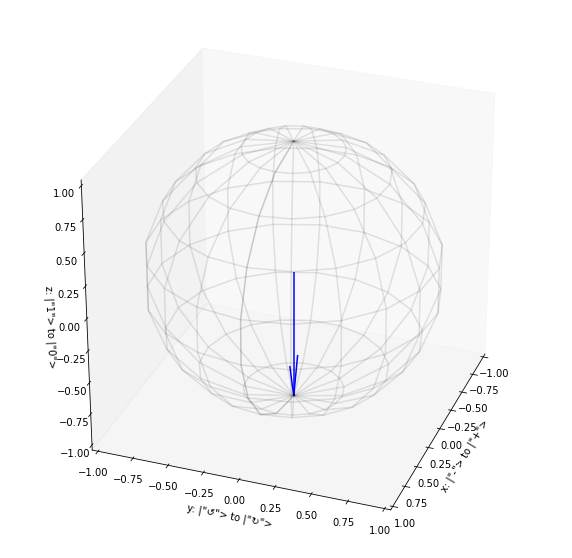

In [ ]:
plot_bloch(X * zero_qubit)

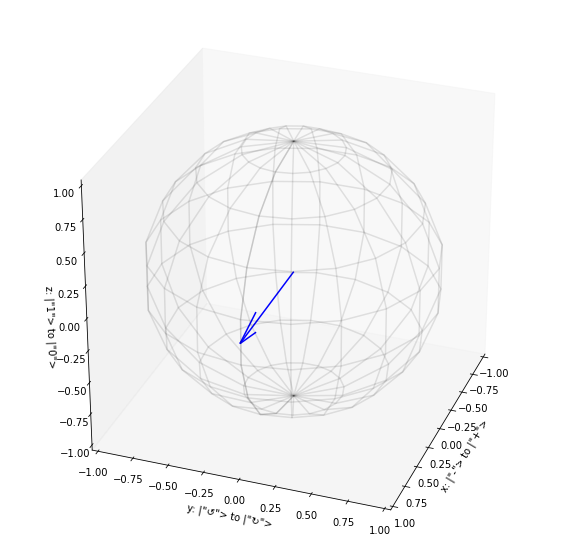

In [ ]:
plot_bloch(H * zero_qubit)

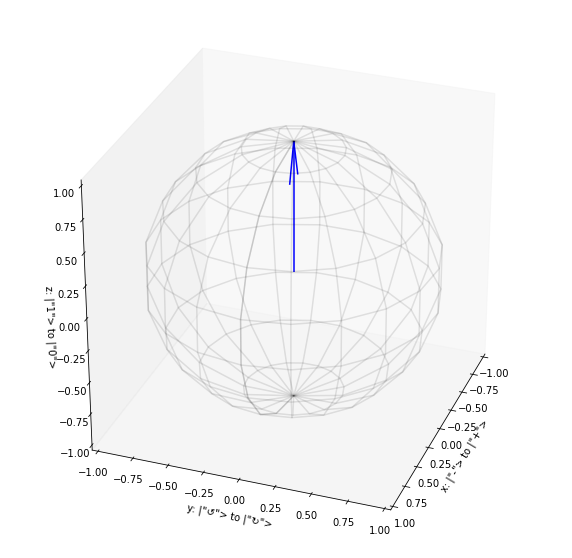

In [ ]:
plot_bloch(H * H * zero_qubit)

## Two qubit gates

The gate for a two qubit state is a 4x4 matrix. The most important two qubit gate is the CNOT, or _Controlled Not_ gate. This gate applies a not to the second qubit in the pair, but only if the first qubit is in the $|1\rangle$ state. The CNOT gate looks like:

$$
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
\end{pmatrix}
$$

Presented like this, the matrix doesn't make much sense, but if we look at how the two-qubit state vector is written, we see

$$
|00\rangle =
\begin{pmatrix}
1 \\
0 \\
0 \\
0 \\
\end{pmatrix},
|01\rangle =
\begin{pmatrix}
0 \\
1 \\
0 \\
0 \\
\end{pmatrix},
|10\rangle =
\begin{pmatrix}
0 \\
0 \\
1 \\
0 \\
\end{pmatrix},
|11\rangle =
\begin{pmatrix}
0 \\
0 \\
0 \\
1 \\
\end{pmatrix},
$$

If you stare at that long enough and think back to the rules we presented for matrix multiplication, you should be able to convince yourself that the CNOT only changes the state of vectors where the first qubit is in state $|1\rangle$ and its action is to flip the state of the second qubit.

The CNOT gate is important because it lets us generate _entanglement_.

**Exercise:** Can you work out $X \otimes X$? Can you verify its operation on the two-qubit basis state vector?

## Quantum vs classical circuits

The quantum circuit model is, at first glance, not radically different than the classical circuit model. But there are important differences:

* Amplitudes for quantum states can be [_complex_](https://en.wikipedia.org/wiki/Complex_number).
* There is no analog of the `H` gate in classical computing, which is to say there is no _superposition_.
* There is no analog of the `CNOT` gate in classical computing, which is to say there is no _entanglement_.
* We require quantum circuits to be _reversible_. Among other things this means we need to have the same number of inputs and outputs. There is no such restriction in classical circuits.
* Measurement in quantum circuits is _probabilisitic_. Which is to say circuits give non-deterministic answers and probabilities are computed using quantum mechanics (which may be regarded as a generalization of classical probability theory to admit negative probabilities). Not all classical circuits are deterministic (there is such a thing as "randomized computation"), but classical circuits obey classical probability laws.

It is fair to ask if these differences can provide any sort of meaningful advantage. It seems reasonable to think we might find algorithms that we can solve faster on quantum circuits than on classical circuits, but we must be formal and rigorous about that fact. It is not easy to prove quantum advantages exist!

The last bullet provides some perspective on where advantages really come from. Quantum computing is best when manipulating probability distributions - entanglement and superposition mean we are able to operate on whole distributions at once, and the admission of "negative probabilities" mean we can leverage _interference_ (both constructive and destructive) in our algorithms.

## Why is quantum computation hard?

If quantum computing can be represented by a circuit model that looks like a richer version of the circuit model used for classical computing, why is it so hard? Why was quantum supremacy so challenging to demonstrate?

The glib answer contains two reasons:

1. The extra richness increases the space of possible algorithms _dramatically_. But many of these possible algorithms actually turn out to be not very useful. Really leveraging the power of the quantum computation model turns out to require a lot of imagination and creativity.

2. Quantum states are very fragile. They are destroyed (collapsed into classical states) by any interaction with the outside world. When this happens unintentionally, we often call it _decoherence_. But - an isolated computer that can't interact with the outside world can't do useful computations! (Or if it does, you can't know about them.) We have to strike a very fine balance and allow just enough communication with, say, a classical control computer to prepare specific states and capture the results of computations while protecting the quantum state from the outside world.

### Noise

This fragility is often called "noise." Noise is a huge and important subject in quantum computing, but we won't say anything about it today other than it exists and if you run on real hardware, you will see it! Gate operations takes time and noise builds up over time - useful quantum computation is always a race between these things.

Problems with noise are why some skeptics believe quantum computing will never be useful. The claim is essentially that the engineering challenges are just too hard to overcome.

## Bell pairs

Many multi-qubit quantum states may be written as the decomposition of single qubit states. For example, $|00\rangle$:

$$
|0\rangle \otimes |0\rangle = |00\rangle = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}
$$

This is just a fancy way of saying the state $|00\rangle$ is made up of two individual qubits in the $|0\rangle$ state sitting next to each other. (Recall - a single qubit has two states, but two qubits has two _squared_, or four different states, so the output product here must have a different dimension.)

All classical states may be written as decompositions in this way, but there are quantum states that cannot be decomposed. We call these states _entangled_. For example, the state

$$
\frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right) =
\frac{1}{\sqrt{2}} \left(
    \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix} +
    \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}
    \right) =
\frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 1 \end{pmatrix}
$$

cannot be broken down into a tensor product of single qubit states. Two qubits in this state is called a "Bell pair".

**Exercise:** Try to find a tensor product of two single qubit states that produces a Bell pair. You won't find one! See if you can prove it isn't possible to produce the state that way.

We can write down a circuit that produces a Bell pair in Qiskit:

In [ ]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.cx(q[0], q[1])
qc.measure(q, c)
qc.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0_0: ═══════════╩══╬═
                    ║ 
c0_1: ══════════════╩═

{'11': 505, '00': 519}


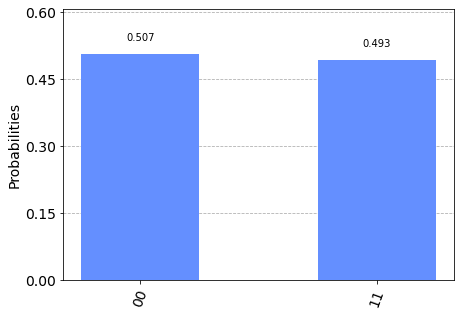

In [ ]:
job_exp = execute(qc, backend=BasicAer.get_backend('qasm_simulator'),
                  shots=1024)
result = job_exp.result()
result_counts = job_exp.result().get_counts(qc)
print(result_counts)
plot_histogram(result_counts)

Note that it always produces paired 0's or 1's. We may also look at the wavefunction directly in Qiskit:

In [ ]:
# Run the quantum circuit on a statevector simulator backend
backend = BasicAer.get_backend('statevector_simulator')

q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.cx(q[0], q[1])

job_exp = execute(qc, backend=BasicAer.get_backend('statevector_simulator'))
result = job_exp.result()
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


Recall $1/\sqrt{2} \approx 0.707$.

The two-qubit wavefunction has four states. We won't work through how to express those states in this lecture, but it is the case that:

$$
\psi = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 \\ 0 \\ 0  \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$

Note that the second gate in our circuit above is a two-qubit gate. It is the CNOT gate, which we saw above. This is the gate that produces entanglement. Recall that CNOT operates on the target qubit only if the control is in the $|1\rangle$ state. What does that mean if the control is in a superposition of states? It must put the target into a superposition of states!

## Quantum Teleportation

What is entanglement good for? Lots of things, but one of the easier to demonstrate in circuits is _quantum teleportation_. Sadly, this not as cool as getting beamed up, but it does provide us a mechanism for transporting an exact quantum state over arbitrary distances.

Recall, entanglement is nothing more than non-separable states. Even though we can't _describe_ an entangled system in terms of individual qubits, we may physically pull the qubits apart while maintaining entanglement.


Why not just copy the state? It turns out that we can't copy quantum states - there is a theorem called the "No Cloning Theorem". The proof turns out to be fairly simple, although we won't go through the details here. But it turns out there is a way to transport a quantum state at the cost of destroying the original copy.

Suppose two people, Alice and Bob, want to teleport a quantum state. If they share a Bell pair of qubits, they can do this. Alice entangles the qubit she wants to teleport to Bob and then they both perform measurements. Note that the measurement Bob performs depends on the outcome of a measurement by Alice, so she must be able to transmit a classical bit of information to him (so we can't use this mechanism for faster-than-light communication, although it turns out we can use mechanisms like this to discover whether there are eavesdroppers attempting to listen in on the communication).

In Qiskit, teleporting from qubit 0 to qubit 2:

In [ ]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)
# create some initial state to teleport
qc.y(q[0])
# insert a "barrier" to prevent gate re-ordering for optimization
qc.barrier()
# create an entangled pair between alice and bob
qc.h(q[1])
qc.cx(q[1], q[2])
# insert a "barrier" to prevent gate re-ordering for optimization
qc.barrier()
# teleportation circuit
qc.cx(q[0], q[1])
qc.h(q[0])
qc.barrier()
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
# depending on what alice and bob find, apply some rotations to the
# teleportation target qubit
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
# if the teleport worked and we measure in the computational basis, we will get
# 0 50% of the time 1 and 50% of the time for an initial prep of Y. so we will
# "cheat" and apply a Y before measuring. Y is its own inverse, so this means
# we should find 0 every time.
qc.barrier()
qc.y(q[2])
qc.measure(q[2], c[2])
qc.draw()

┌───┐ ░            ░      ┌───┐ ░ ┌─┐            ░         
q9_0: ┤ Y ├─░────────────░───■──┤ H ├─░─┤M├─────────■──░─────────
      └───┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐      │  ░         
q9_1: ──────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──■───┼──░─────────
            ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘┌─┴─┐ │  ░ ┌───┐┌─┐
q9_2: ──────░──────┤ X ├─░────────────░──╫──╫─┤ X ├─■──░─┤ Y ├┤M├
            ░      └───┘ ░            ░  ║  ║ └───┘    ░ └───┘└╥┘
c9_0: ═══════════════════════════════════╩══╬══════════════════╬═
                                            ║                  ║ 
c9_1: ══════════════════════════════════════╩══════════════════╬═
                                                               ║ 
c9_2: ═════════════════════════════════════════════════════════╩═

Looking at the wavefunction turns out to be sort of hard to interpret because we can have a variety of outcomes in qubits 0 and 1. But if we look at many "shots" with the circuit:

{'000': 236, '010': 270, '001': 260, '011': 258}


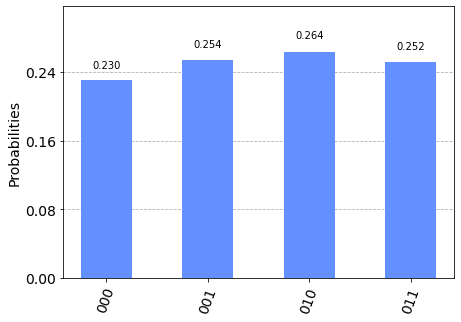

In [ ]:
job_exp = execute(qc, backend=BasicAer.get_backend('qasm_simulator'),
                  shots=1024)
result = job_exp.result()
result_counts = job_exp.result().get_counts(qc)
print(result_counts)
plot_histogram(result_counts)

Note that the IBM results are ordered $c_2 c_1 c_0$ - so we only see $c_2 = 0$ results as expected.

## More on quantum circuits

Let's build some circuits. Qiskit code might look very confusing (or very clear, depending on your perspective), but IBM's [quantum composer](https://quantum-computing.ibm.com) is a fun and totally visual tool for this task. You can sign up for a free account to use the tools on the web, and as a bonus you can run the circuits you design on real quantum hardware!

## Swapping two qubits

If we have time, we can look at swapping two qubits. This is similar to teleportation, but it is local to the circuit. Suppose we are doing a calculation on these qubits:

<img src="https://www.dropbox.com/s/pqemqzoxhy1z09m/registerofqubits.png?dl=1">

What if we can only apply two-qubit gates on neighbors because that is the best our laser can do. Now what if we are doing a calculation where we need to act with a two qubit gate on the first and third qubits? We have to swap qubits 1 and 2, apply our gate, and then swap back.

How do we swap? We use three CNOT gates.

First, let's build up an interesting state on qubit zero, just for fun:

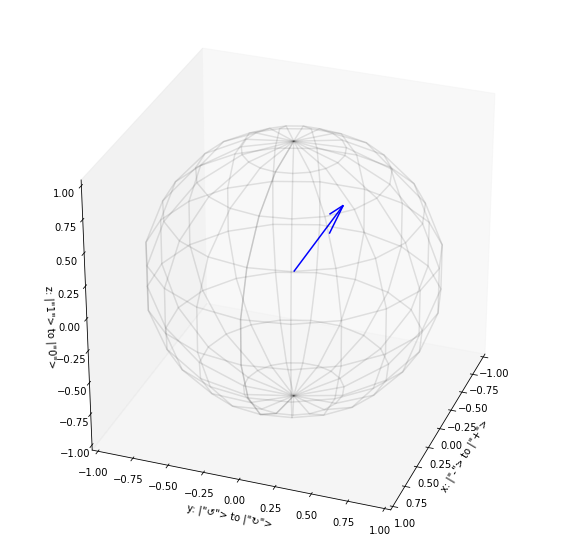

In [ ]:
plot_bloch(Y * H * zero_qubit)

In [ ]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr)
circuit.h(qr[0])
circuit.y(qr[0])
circuit.draw()

┌───┐┌───┐
q10_0: ┤ H ├┤ Y ├
       └───┘└───┘
c10_0: ══════════

In [ ]:
job_exp = qiskit.execute(circuit, backend=BasicAer.get_backend('statevector_simulator'))
result = job_exp.result()
outputstate = result.get_statevector(circuit, decimals=3)
print(outputstate)

[ 0.707+0.j -0.707+0.j]


Now, consider a two qubit register:

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h(qr[0])
circuit.y(qr[0])
circuit.draw()

┌───┐┌───┐
q11_0: ┤ H ├┤ Y ├
       └───┘└───┘
q11_1: ──────────
                 
c11_0: ══════════
                 
c11_1: ══════════

In [ ]:
job_exp = qiskit.execute(circuit, backend=BasicAer.get_backend('statevector_simulator'))
result = job_exp.result()
outputstate = result.get_statevector(circuit, decimals=3)
print(outputstate)

[ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]


Now, let's apply the swap operation - it is 3 CNOT gates:

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h(qr[0])
circuit.y(qr[0])
circuit.cx(qr[0], qr[1])
circuit.cx(qr[1], qr[0])
circuit.cx(qr[0], qr[1])

circuit.draw()

┌───┐┌───┐     ┌───┐     
q12_0: ┤ H ├┤ Y ├──■──┤ X ├──■──
       └───┘└───┘┌─┴─┐└─┬─┘┌─┴─┐
q12_1: ──────────┤ X ├──■──┤ X ├
                 └───┘     └───┘
c12_0: ═════════════════════════
                                
c12_1: ═════════════════════════

In [ ]:
job_exp = qiskit.execute(circuit, backend=BasicAer.get_backend('statevector_simulator'))
result = job_exp.result()
outputstate = result.get_statevector(circuit, decimals=3)
print(outputstate)

[ 0.707+0.j  0.   +0.j -0.707+0.j  0.   +0.j]


**Exercise:** Did we actually swap the qubits? Try to decompose the state above. Or, take the tensor product of the original two qubits and take the tensor product again assuming we did a swap. Does the swap assumption look right?

Just to prove this isn't hopeless, you can compute the state vector for the two qubit system using Qiskit with our special state creation elements applied to the second qubit:

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h(qr[1])
circuit.y(qr[1])

circuit.draw()

q13_0: ──────────
       ┌───┐┌───┐
q13_1: ┤ H ├┤ Y ├
       └───┘└───┘
c13_0: ══════════
                 
c13_1: ══════════

In [ ]:
job_exp = qiskit.execute(circuit, backend=BasicAer.get_backend('statevector_simulator'))
result = job_exp.result()
outputstate = result.get_statevector(circuit, decimals=3)
print(outputstate)

[ 0.707+0.j  0.   +0.j -0.707+0.j  0.   +0.j]


**Exercise:** Play with the code in the swap circuit by commenting out CNOTs. (Put a `#` in front of the line of code you want to "remove".) Also try playing with the "special state preparation" gates we used. There is no specific question here - just see if can start to see how applying different types of entanglement changes the system.

## Appendix

### Computational complexity

_Time_ is a resource quantum information specialists spend a great deal of effort thinking about. This is because it is easily abstracted using the notion of _[computational complexity](https://en.wikipedia.org/wiki/Computational_complexity)_. An important focus of academic computer science is computing the _scaling_ for algorithms. This is largely figuring out how long algorithms run as the inputs "go to infinity" - so for example, if we want to sort a list of $n$ items, how does the algorithm scale as $n$ grows larger and larger, etc.

There are many approaches to computing scaling properties, but a common method is to use _[Big-O notation](https://en.wikipedia.org/wiki/Big_O_notation)_. Big-O notation involves studying only the _leading term_ in a scaling calculation.

| names | example expression | Big-O |
|-------|--------------------|-------|
| constant | 1, 10, 1e6 | O(1) |
| logarithmic | 3 log$_{10} n$, 2 log$_{2} n$ | O(log($n$)) |
| linear | 5$n$, 10$n$ - $\log_2 n$ | O($n$) |
| n-log-n | $4 n \log_2 n$, $n \log_2 n + 10n$ | O($n \log n$) |
| quadratic | $n^2 + 2n + 1$, $n^2 + 100 n \log_2 n$ | O($n^2$) |
| exponential | $2^n$, $3 e^n + 10 n^4$ | O($c^n$) |

Note that algorithm's order is not the same as its speed. If you have a sorting algorithm that scales like $2^n + 1$, that will be faster than one that scales like $n \log_2 n + 1000000$ for small values of $n$, but as $n \to \infty$ (as we add more items to our list to sort), the alogorithm with exponential scaling will become _much_ slower.

### Boolean algebra and computation

Two-level systems also let us represent a more general type of computation, namely [Boolean algebra](https://en.wikipedia.org/wiki/Boolean_algebra). This is essentially a mathematics of true and false. It gives us powerful tools for expressing logical conditions and statements. It is the foundation for digital logic and therefore the foundation for "classical" computing (more on this soon). Even better, we have systems built in silicon that are able to implement two-level systems and control huge numbers of them with high precision and speed. These systems are what most of us think of when we think of [computers](https://en.wikipedia.org/wiki/Computer).